# [EINT] Tutorial: Automatic DCM of ERPs; Bayesian Inference on an ODE  model of NeuroImaging using Numpyro 

Nina Baldy INS-AMU 

Meysam Hashemi, INS-AMU,

Main Ref: https://www.biorxiv.org/content/10.1101/2024.11.06.622230v1

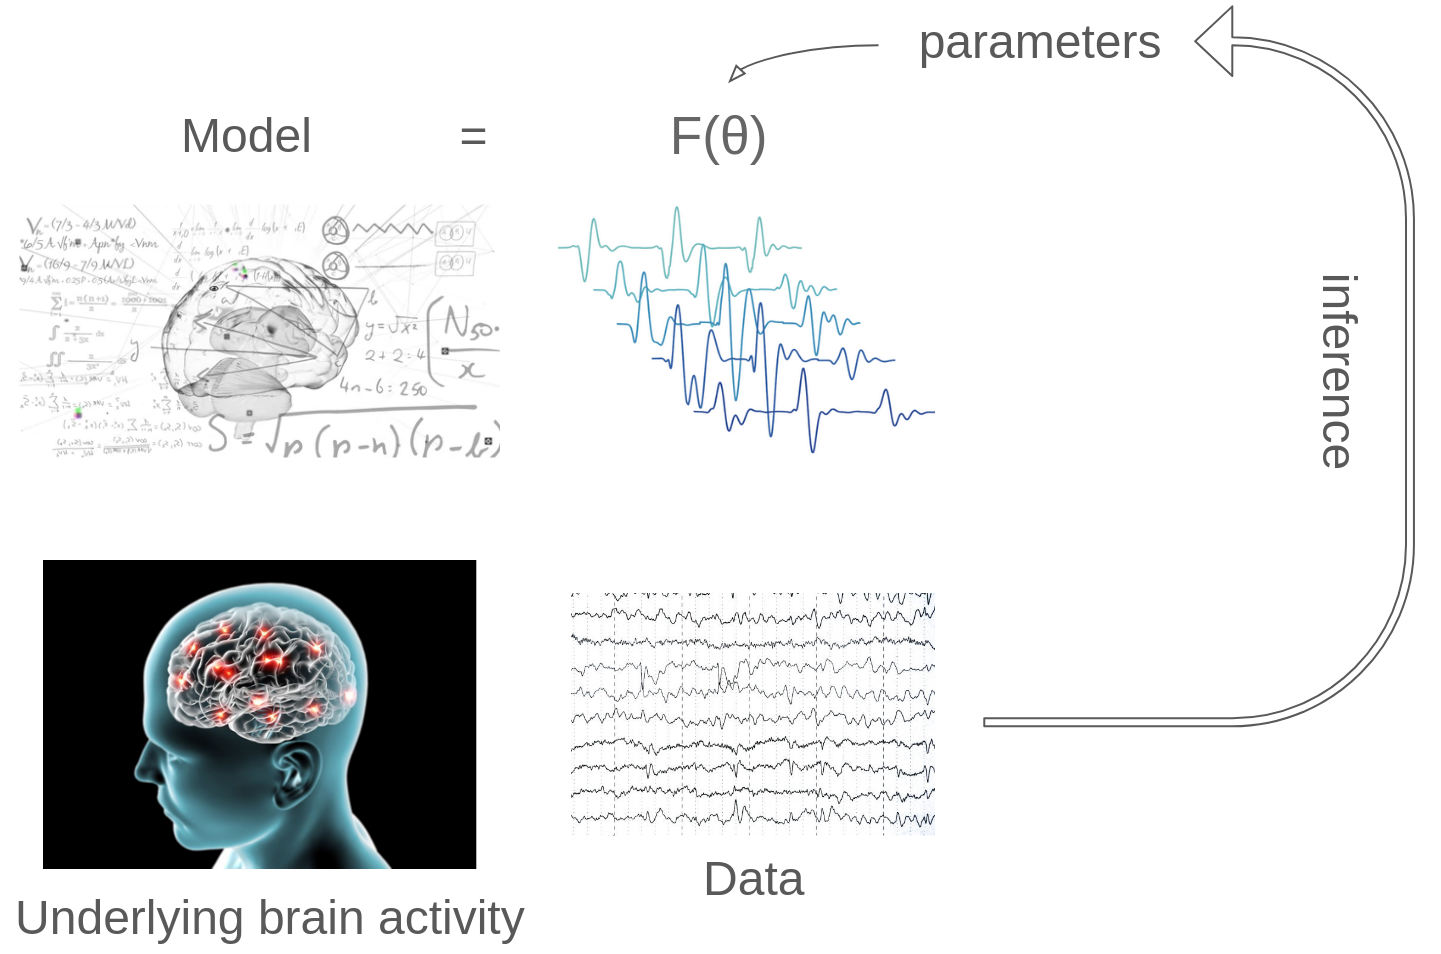

In [1]:
from IPython.display import Image
Image(filename='Figs/model_inference.png', width=1000)

# What is inference ?

**Inference** is the process of drawing conclusions about phenomena that cannot be observed directly.  Hence, we draw inferences from available **data** using logical reasoning or statistical methods. Statistical inference leverages mathematical tools to learn from data. For example, if we aim to understand how the brain processes information based on neuroimaging recordings, we cannot measure all neural activities and their interactions directly, but we can infer the underlying processes using **models**.


# What is a model?

A **model** is a simplified representation of a real-world system or process, designed to help us understand phenomena and make predictions based on data or observations. In computational neuroscience, models are often mathematical equations that describe how different components of the brain—such as neurons and regions—interact with each other and how brain activity evolves over time. Models can be derived from fundamental principles of physics or biology (mechanistic) or take the form of more abstract representations (phenomenological). Ultimately, every model relies on assumptions about the phenomenon it seeks to describe. Since models are simplifications, they do not perfectly represent the real world. However, they can still provide valuable insights, capture essential system features, and enable predictions. As the statistician George Box famously said, **"All models are wrong, but some are useful."** So, in this notebook, we aim to make one of these models useful for neuroimaging recordings!


In this tutorial, we will work with a  **neural mass model** formulated using **Ordinary Differential Equations (ODEs)** (see  [Ref 1]). An ODE is a mathematical equation that describes how a system evolves over time by computing derivatives, allowing us to model the macroscopic activity of neuronal populations and how brain dynamics unfold over time. These models provide a deterministic representation of neural processes, but real-world data exhibit variability due  to biological variability, external perturbations, and measurement errors.


To account for this, **statistical models**  incorporate randomness and uncertainty, assuming that observed data arise from a process involving both deterministic and random components. In other words, statistical models account for the inherent variability or noise present in the real-world data. For example, when modeling brain activity, a statistical model represents not only the underlying neural processes but also random fluctuations or errors in the observed data—such as measurement noise caused by imperceptible electrode movements. 


By formulating a neural mass model as a **state-space model**, we introduce a structured **probabilistic framework**, where the true neural states are latent and inferred from noisy observations. The state equation describes how neural states evolve over time, following the ODE-based model, while the observation equation defines how these states generate the recorded data, incorporating measurement uncertainty. This allows for **Bayesian inference**, enabling us to estimate latent neural states, quantify uncertainty, and improve predictive accuracy when analyzing neuroimaging data. Using Bayesian inference, instead of treating model parameters and states as fixed values, we can estimate them in a probabilistic manner, quantifying uncertainty in both neural dynamics and observations.

Recommendation for reading: 


https://github.com/peteflorence/MachineLearning6.867/blob/master/Bishop/Bishop%20-%20Pattern%20Recognition%20and%20Machine%20Learning.pdf


https://github.com/fehiepsi/rethinking-numpyro



 

# What are the parameters?

**Parameters** are values in the model that determine its behavior. For instance, in a model of brain activity, parameters might represent the strength of connections between brain regions or how quickly neurons respond to stimuli. In statistics, parameters specifically refer to unknown quantities that must be estimated from data.

When **estimating parameters**, we aim to infer the values that best explain the observed data. In **Bayesian setting**, parameters are treated as random variables and represented by **probability distributions**. 
rather than single fixed values. This propbabalitic approach allows us to capture a range of plausible values, accounting for **uncertainty** in both data and model, leading to more robust and interpretable inferences.



# Bayesian Inference: combining prior knowledge with data

In **Bayesian inference**, we begin with a **prior distribution**, which represents our initial beliefs about the parameters, before observing any data. This prior can be informed by previous research, expert knowledge, or, when no prior information is available, a neutral uniform (diffuse) distribution.

As we collect data, we apply, we apply Bayes' theorem to update our beliefs through the **likelihood functions**. The observed data refine our estimates, yielding a  **posterior distribution**: a probability distribution that reflects what we know about the parameters after incorporating the data.


In mathematical terms, Bayes' theorem is expressed as:

$$P(\theta | \text{data}) = \frac{P(\text{data} | \theta) P(\theta)}{P(\text{data})}$$

where:
* $P(\theta | \text{data})$ is the posterior distribution representing the updated belief about the parameters θ given the observed data,
 
* $P(\text{data} | \theta)$ is the likelihood, describing how probable the observed data, given certain parameter values,

* $P(\theta)$ is the prior, capturing the initial belief about θ before observing data,

* $P(\text{data})$ is the evidence (or marginal likelihood), acting as a normalization constant to ensure the posterior is a valid probability distribution.


For more details, see: van de Schoot, R., Depaoli, S., King, R. et al. Bayesian statistics and modelling. Nat Rev Methods Primers 1, 1 (2021). https://doi-org.proxy.insermbiblio.inist.fr/10.1038/s43586-020-00001-2

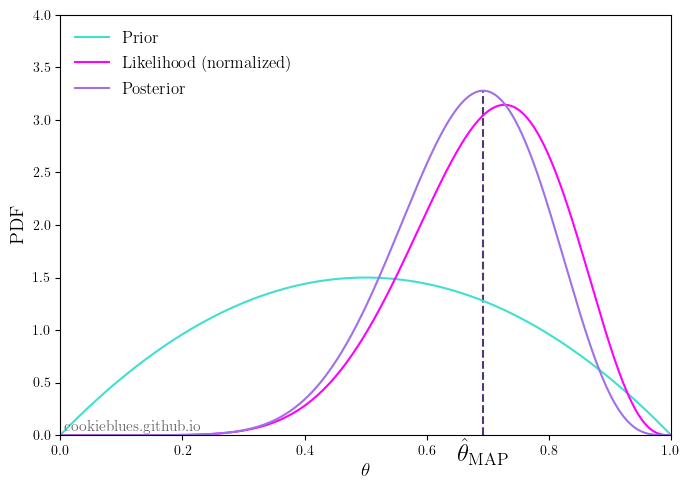

In [2]:
Image(filename='Figs/bayes.png', width=600)

## A neural mass model of ERPs, expressed as an ODE model: 

A derivation of **Jansen-Rit model** is used in **Dynamical Causal Modeling (DCM)** and other approaches to fit various neuroimaging data, such as **event-related potentials (ERPs)** observed in EEG/MEG recordings  [Ref 2]. It is defined by a system of 9 coupled ODEs, describing the temporal evolution of neural sources in three populations:



\begin{array}{l}
\frac{dx_{1}(t)}{dt} = x_{4}(t) \\
\frac{dx_{2}(t)}{dt} = x_{5}(t) \\
\frac{dx_{3}(t)}{dt} = x_{6}(t) \\
\frac{dx_{7}(t)}{dt}  = x_{8}(t) \\
\frac{dx_{4}(t)}{dt} = \frac{{h_{e}(g_{1}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5) + u)}}{{\tau_{e}}} - \frac{{x_{1}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{4}(t)}}{{\tau_{e}}} \\
\frac{dx_{5}(t)}{dt}  = \frac{{h_{e}g_{2}(\frac{1}{e^{-0.56x_{1}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{2}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{5}(t)}}{{\tau_{e}}} \\
\frac{dx_{6}(t)}{dt}  = \frac{{h_{i}g_{4}(\frac{1}{e^{-0.56x_{7}(t-\delta)}+1} - 0.5)}}{{\tau_{i}}} - \frac{{x_{3}(t)}}{{\tau_{i}^{2}}} - \frac{{2x_{6}^{t}}}{{\tau_{i}}} \\
\frac{dx_{8}(t)}{dt}  = \frac{{h_{e}g_{3}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{7}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{8}(t)}}{{\tau_{e}}} \\
\frac{dx_{9}(t)}{dt}  = x_{5}(t) - x_{6}(t)
\end{array}

where, the state vector $X(t)=[x_1(t), ...x_9(t)]^T$ comprises the activity of the 9 sources. 
$X(0)$ represents the initial values of the states needed to solve the ODE and is fixed to zero for all variables.

The model comprises three interconnected neural populations: 
* spiny-stellate cells ($x_1$), which receive the external input current, 
* inhibitory interneuron ($x_7$),
* excitatory pyramidal neurons ($x_9$), the only **observed** population.  In this case, we reffer to the other states as latent or hidden variables.

**Model parameters** $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the **unknowns** that we wish to infer from experimental observations (here the activity of pyramidal neurons), where:

* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ the intrinsic time-delay.
* $h_{e,i}$ the maximum amplitude of excitatory (e) and inhibitory (i) post-synaptic potentials, respectively.
* $\tau_{e, i}$ the rate constants for excitatory and inhibitory synaptic inputs, respectively.
* $u$  the input current.


A schematic illustration of the model is:

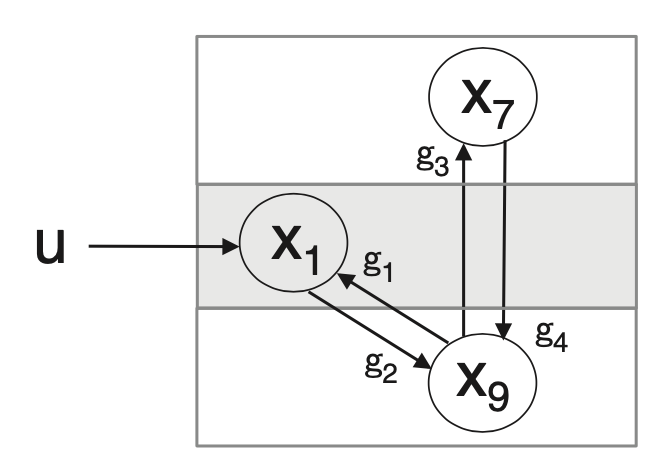

In [3]:
Image(filename='Figs/model.png', width=400)

# Let's run the code

It is recommended to create a **virtual environment** as we need specific versions of JAX and NumPyro that are not the most recent ones and can (will!) create conflict with other packages. 

To create a virtual environment: https://janakiev.com/blog/jupyter-virtual-envs/

Example with conda:
* conda create -n numypro_env python=3.10
* conda activate numypro_env
* (numpyro_env) sudo apt install python3-pip
* (numpyro_env) pip install --user ipykernel
* (numpyro_env) python3 -m ipykernel install --user --name=numpyro_env

Let's install and import the python packages we will use. If a package to import is missing, it can be installed with the command "!pip install name-of-the-package", or if you use a virtual environment magic command % and pip.


%pip install jaxlib==0.4.13

%pip install jax==0.4.13

%pip install arviz==0.20.0

%pip install graphviz==0.20.3

%pip install numpyro==0.12.1

%pip install scipy==1.12.0

%pip install seaborn


Now lets to shoot!

In [4]:
import os
import sys
import time
import timeit
import pathlib

#Basic computations
import numpy as np

#Visualizaton
import matplotlib.pyplot as plt
%matplotlib inline

import arviz as az
import graphviz
az.style.use("arviz-darkgrid")

import seaborn as sns
from pandas import DataFrame

#jax is package for automatic differentation, i.e. computing gradients
import jax 
import jax.numpy as jnp
from jax import grad, vmap, lax, random
from jax.experimental.ode import odeint

#optimization algorithm we will try before bayesian inference
import scipy
from scipy.optimize import differential_evolution

#numpyro is a jax-based package for inference
import numpyro as npr
from numpyro import sample, plate, handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_sample

/opt/anaconda3/envs/numypro_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
npr.set_platform("cpu")

In [6]:
#print the versions of the packages we imported
print(f"Numpy version: {np.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {npr.__version__}")
print(f"Arviz version: {az.__version__}")

Numpy version: 1.26.4
scipy version: 1.12.0
JAX version: 0.4.13
Numpyro version: 0.12.1
Arviz version: 0.20.0


In [7]:
import multiprocessing

#set up for parallelizing the chains

def setup_parallelization():
    num_cores = multiprocessing.cpu_count()
    os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={num_cores}"
    jax.config.update("jax_enable_x64", True)
    jax.config.update("jax_platform_name", "cpu")
    print(f"Number of CPU cores: {num_cores}")
    print(f"Using devices: {jax.devices('cpu')}")

In [8]:
enable_parallelization = True

if enable_parallelization:
    setup_parallelization()
    print("Parallelizing chains.")
else:
    print("Skipping parallelization setup.")

Number of CPU cores: 8
Using devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]
Parallelizing chains.


# Simulating the model

One of the key advantages of models is their ability to **simulate data**, allowing us to generate synthetic observations that replicate real-world behavior under different conditions.


To better reflect real-world scenarios, we will introduce noise into these simulations, mimicking the variability present in actual neuroimaging data. By working with these noisy simulated observations, we can evaluate our inference approach in a controlled setting, where the true underlying parameters are known, enabling us to assess its accuracy and robustness


To find a set of functions that satisfy the system of **Ordinary Differential Equations (ODEs)**, we must integrate the system numerically. One of the simplest methods for doing so is **Euler’s Method**, which approximates the solution by iterating forward in small time steps. Euler’s Method works by estimating the derivative at each step using the slope at the current point. Given an initial condition, for example, $t=0$ and $X(0) = X_0=0$ and the next value of $X$ is computed as: $X(t+h) = X(t) + h * \frac{dX}{dt}$, where $h$ is the step size.
We update $t$ to $t+h$,

We then update $t$ to $t+h$, and repeat the process, generating a stepwise approximation of how the system evolves over time. While Euler’s Method is straightforward, it may introduce numerical errors, particularly for stiff or highly dynamic systems. More advanced integration methods, such as Runge-Kutta methods, are often preferred for greater accuracy and stability. However, Euler’s Method provides an intuitive starting point for understanding numerical integration in ODE-based models. 

In [9]:
def odeint_euler(f, x0, t, *args):
    
    def step(state, t):
        x_prev, t_prev = state
        h = t - t_prev
        x = x_prev + h * f(x_prev, t_prev, *args)
        return (x, t), x
    
    _, xs = lax.scan(step, (x0, t[0]), t[0:]) #it's like a "for" loop but better

    return xs

Now, we need to translate the system of ODEs into code that can be processed by JAX. This step is straightforward: we define a function that takes as input the current state $X$, the time tt at which the system is evaluated, and the model parameters. Inside this function, we implement the nine equations that describe the derivatives of the system with respect to time. The function then returns a vector containing these nine derivatives, which will be used for numerical integration.

Here’s a structured approach:

    1. Define a function that takes $X$, $t$, and the parameters as input.
    2. Implement the system of ODEs by computing each derivative.
    3. Return a vector containing all computed derivatives.

This function serves as the core for integrating the system over time using JAX-compatible numerical solvers.

In [10]:
# we set the constants
C=-0.56
constants=jnp.array([C])

In [11]:
#sigmoid function
@jax.jit
def Sigmodal(x1, x2, delta, c):
    S=(1./(1.+jnp.exp(c*(x1-(delta*x2)))))-0.5
    return S

In [12]:
#ODES
@jax.jit
def ERP_model(state, t, params):
    """
    Returns the derivatives of each state with respect to time t.
    """
    x0, x1, x2, x3, x4, x5, x6, x7, x8 = state
    g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u  = params
    
    c = constants[0]

    dx0 = x3
    dx1 = x4
    dx2 = x5
    dx6 = x7
    dx3 = (1./tau_e) * (h_e * (g_1 * (Sigmodal(x8, x4 - x5, delta, c)) + u) - (x0 / tau_e) - 2 * x3)
    dx4 = (1./tau_e) * (h_e * (g_2 * (Sigmodal(x0, x3, delta, c))) - (x1 / tau_e) - 2 * x4)
    dx5 = (1./tau_i) * (h_i * (g_4 * (Sigmodal(x6, x7, delta, c))) - (x2 / tau_i) - 2 * x5)
    dx7 = (1./tau_e) * (h_e * (g_3 * (Sigmodal(x8, x4 - x5, delta, c))) - (x6 / tau_e) - 2 * x7)
    dx8 = x4 - x5

    return jnp.array([dx0, dx1, dx2, dx3, dx4, dx5, dx6, dx7, dx8])

Let's define all the quantities we need for the simulation:

In [13]:
t_0 = 0.0  # starting value for time t
t_end = 200.0 # end value for time t
h = 0.1 # the step size for euler intergration

# we create a discretized vector of time points to integrate at
ts = np.arange(t_0, t_end + h, h)
nt = ts.shape[0]

In [14]:
ns = 9 #number of variables

# we set initial conditions for X: X(t_0) = 0
x_init = np.zeros((ns))

In [15]:
# The true parameter values
params_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])
n_params = theta_true.shape[0]

And we can now integrate the equations. The magic command %%time placed at the beggining of a cell returns the CPU and wall times used to run that cell.

Remember, in this model, only the voltage from  the pyramidal neurons ($x_9$) is considered to be **observable**. 

In [16]:
%%time
xs_odeint = odeint_euler(ERP_model, x_init, ts, theta_true)

CPU times: user 200 ms, sys: 71.3 ms, total: 272 ms
Wall time: 577 ms


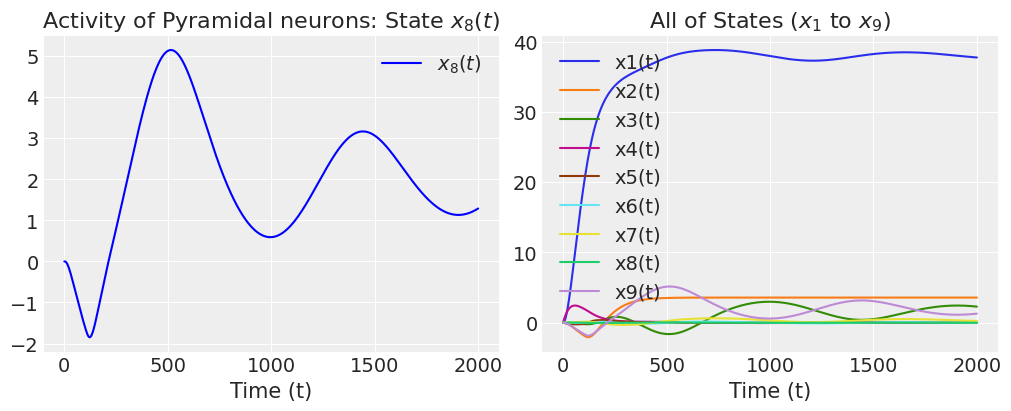

In [17]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(xs_odeint[:, 8], label=r'$x_8(t)$', color='b')  
plt.legend(loc='best')
plt.title('Activity of Pyramidal neurons: State $x_8(t)$')
plt.xlabel('Time (t)')

plt.subplot(1, 2, 2)
for istate, state in enumerate(xs_odeint.T) :
    plt.plot(state, label='x' + str(istate+1) + '(t)')
plt.legend(loc='best')
plt.title('All of States ($x_1$ to $x_9$)')
plt.xlabel('Time (t)')

plt.show()

We prepare a simulator that outputs only the observable variable, $x_9$. 

**Remark**: We still need to integrate the entire system, as the variables are interdependent. This simulator function will be used for inference.

In [18]:
@jax.jit
def ERP_simulator(x_init, ts, params):
    xs_odeint = odeint_euler(ERP_model, x_init, ts, params)    
    x_py = xs_odeint[:,8] 
    return x_py

With JAX's jit, the first compilation (i.e., the first function call) is slightly slower, but subsequent calls are significantly faster. Run the following code block to compile the simulator. The initial compilation time is roughly equivalent to the integration we performed a few cells above.

In [19]:
%%time 
xpy_odeint = ERP_simulator(x_init, ts, theta_true)

CPU times: user 104 ms, sys: 6.59 ms, total: 111 ms
Wall time: 106 ms


Now run it for the second time:

In [20]:
%%time 
xpy_odeint = ERP_simulator(x_init, ts, theta_true)

CPU times: user 315 μs, sys: 79 μs, total: 394 μs
Wall time: 215 μs


# Generating synthetic observation

As mentioned in the introduction, the model will not follow real-world data exactly. To make the outputs more realistic, we add some noise to the integrator’s results. Specifically, we will use independently distributed Gaussian (Normal) noise. This will introduce variability to the model outputs, simulating the measurement noise present in real-world observations.

**Remark**: For inherent dynamical noise, the process becomes more challenging, as we need numerical integrators for Stochastic Differential Equations (SDEs). The main challenge then lies in estimating the dynamical noise, as the observation will behave differently at each instant, introducing variability that must be accounted for in the model.

JAX uses keys for its random number generator. 
In the follwoing, we create a vector of gaussian distributed noise with mean 0 and variance sigma
sigma = 0.1, and we add this noise to the output of the integration (residual noise).

In [21]:
sigma=0.1

In [22]:
rng_key = jax.random.PRNGKey(0) #we use seed=0

In [23]:
x_noise = np.random.normal(loc=0, scale=sigma, size=xpy_odeint.shape)

In [24]:
x_py = xpy_odeint + x_noise

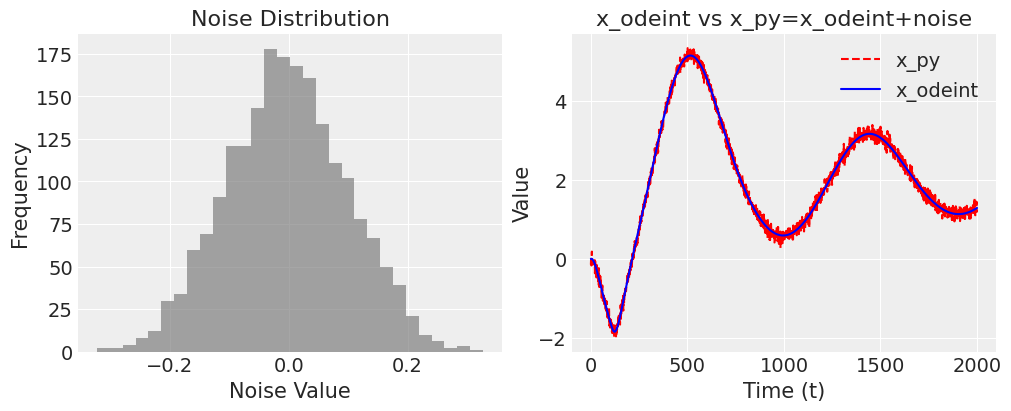

In [25]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(x_noise, bins=30, color='gray', alpha=0.7)
plt.title('Noise Distribution')
plt.xlabel('Noise Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(x_py, label='x_py', color='r', linestyle='--')
plt.plot(xpy_odeint, label='x_odeint', color='b')
plt.legend(loc='best')
plt.title('x_odeint vs x_py=x_odeint+noise')
plt.xlabel('Time (t)')
plt.ylabel('Value')

plt.show()

Importantly, for the sake of faster inference, we will downsample our observations by a factor of 10. This will reduce the data size and speed up the computational process, while still maintaining a reasonable approximation of the underlying dynamics.

Questions: The cost will reduce also by a factor of 10?

In [26]:
ds = 10
ts_obs = ts[::ds]
xpy_obs = x_py[::ds]
nt_obs = int(x_py[::ds].shape[0])

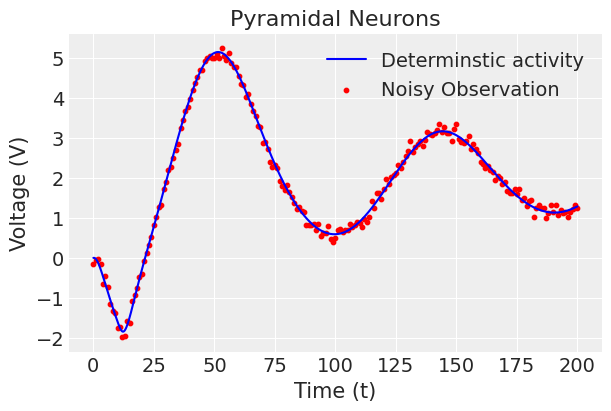

In [27]:
plt.figure(figsize=(6, 4))
plt.plot(ts, xpy_odeint, label='Determinstic activity', color='b')
plt.scatter(ts_obs, xpy_obs, color='red', s=10, label='Noisy Observation')
plt.legend()
plt.title('Pyramidal Neurons')
plt.xlabel('Time (t)') 
plt.ylabel('Voltage (V)') 
plt.show()

We then wrap our data in a dictionnary that we will later pass for inference:

In [28]:
data = {
    'nt_obs': nt_obs, 
    'ds': ds, 
    'ts': ts, 
    'ts_obs': ts_obs, 
    'h': h, 
    'x_init': x_init, 
    'obs_err': sigma, 
    'xpy_obs': xpy_obs }

# Inference

Now that we have our "data", we will explore how we can infer the parameters used to generate this data. Since we already know the true parameters, it will be easy to validate the inference. However, when using real-world data, things can become more complex, as we may not have access to the true underlying parameters and must rely on approximations or prior knowledge


# Inference using optimization 

**Optimization** methods (like gradient descent or other optimization algorithms) aim to find a single set of parameters, that minimizes or maximizes an **objective function**, often a measure of error between the model's predictions and the observed data.One commonly used **loss function** is the **mean squared error (MSE)**, defined as:

$$ MSE(x, \hat x) = \frac{1}{N_x}\sum \limits _{i=1}^{N_x} (x_i - \hat x_i)^2$$

where: 
    $x$ is the true data we aim to fit,
    $\hat x$ is the data generated using the proposed parameters, and
    $N_x$ is the total number of data points.


Once the model is fitted, optimization methods provide a **point estimate** of the parameters. This point estimate corresponds to **the single set of parameter** values that best fit the data according to the chosen objective function.

we use np.nan_to_num to transform "nan" values (errors basically) into a very large number, which will induce a very high loss:


In [29]:
def loss_fun(params) :
    xpy_sim = ERP_simulator(data['x_init'], data['ts'], params)[::data['ds']]
    mse = np.mean((np.nan_to_num(xpy_sim, nan=1e6) - data['xpy_obs'])**2)
    return mse

In [30]:
def callback(intermediate_result):
    trace_loss.append(intermediate_result.fun)
    trace_prms.append(intermediate_result.x)

In the follwoing we use **differential_evolution** as a global search metaheuristic optimization algorithms, whioch does not need the initial values as they are taken randonly, but we have to define bounds for the parameter values:

In [31]:
trace_loss = []
trace_prms = []


bounds = [(1e-4, 1.0), (1e-4, 1.0), (1e-4, 1.0), (1e-4, 1.0), 
          (1e-4, 20.0), (1e-4, 10.0), (10.0, 50.0), (1e-4, 10.0), 
          (1e-4, 10.0), (1e-4, 10.0)]

In [32]:
start_time = time.time()
res = differential_evolution(loss_fun, 
                             bounds=bounds, 
                             popsize=5, 
                             maxiter=500, 
                             callback=callback, 
                             polish=False,
                             seed=0)
print("Scipy DE took (sec):" , (time.time() - start_time))

Scipy DE took (sec): 16.092823028564453


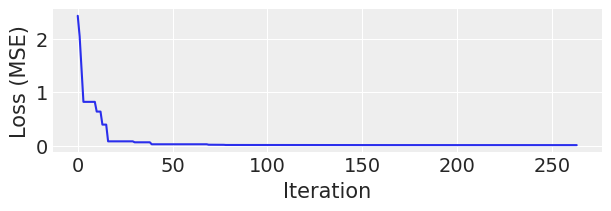

In [33]:
plt.figure(figsize=(6, 2)); plt.plot(trace_loss); 
plt.xlabel('Iteration') ; plt.ylabel('Loss (MSE)'); plt.show()

The loss function has stabilized, which in practice is used to decide for convergence of the optimization. 
The optimized parameters are stored as ".x" in the resulting object.
We will print gound truth parameters and the estimated values: 

In [34]:
opt_params = res.x

compared = DataFrame(dict(params=params_names, true=theta_true, opt=opt_params))
compared

,params,true,opt
0,g_1,0.42,0.817668
1,g_2,0.76,0.884051
2,g_3,0.15,0.353748
3,g_4,0.16,0.047659
4,delta,12.13,12.856363
5,tau_i,7.77,7.594400
6,h_i,27.87,47.002717
7,tau_e,5.77,5.456205
8,h_e,1.63,1.442289
9,u,3.94,9.952090


See that the values are close enough, but they are not the same (especially those that have degerancy, such as h_i).

We will do a simulation using the parameters found by the optimizer, and we plot it along the observations, and we also plot the estimated values of parameters next to the true values:

In [35]:
sim = ERP_simulator(data['x_init'], data['ts'], res.x)[::data['ds']]

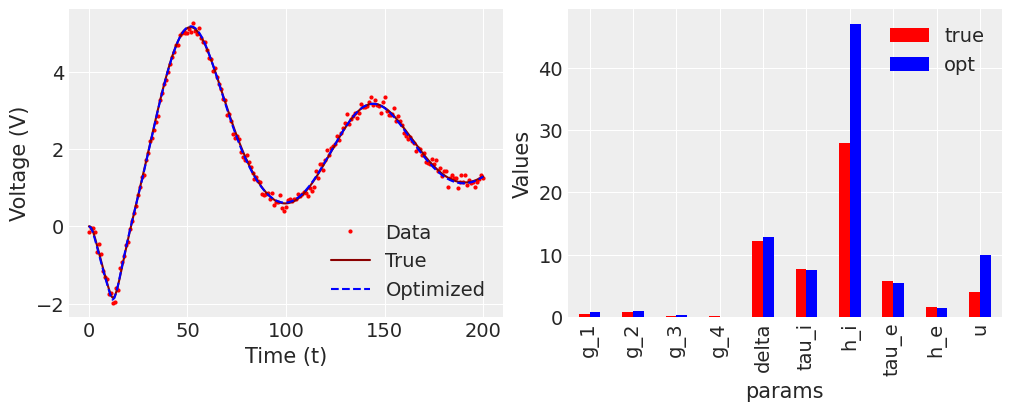

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

ax[0].plot(xpy_obs, 'or', markersize=2, label='Data') 
ax[0].set_xlabel('Time (t)')  
ax[0].set_ylabel('Voltage (V)')  
ax[0].plot(data['ts'], xpy_odeint, color='darkred', label='True') 
ax[0].plot(sim, 'b--', label='Optimized') 
ax[0].legend()

compared.plot(x='params', kind='bar', ax=ax[1], color=['red', 'blue'])
ax[1].set_ylabel('Values')

plt.show()

Try to run again the optimization scheme with another random seed, by changing seed= to another number in the call to differential_evolution. Do you get the same results?

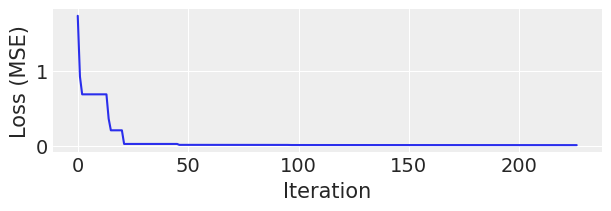

In [37]:
trace_loss = []
trace_prms = []


res = differential_evolution(loss_fun, 
                             bounds=bounds, 
                             popsize=5, 
                             maxiter=500, 
                             callback=callback, 
                             polish=False,
                             seed=1)

plt.figure(figsize=(6, 2)); plt.plot(trace_loss); 
plt.xlabel('Iteration') ; plt.ylabel('Loss (MSE)'); plt.show()

In [38]:
opt_params = res.x

compared = DataFrame(dict(params=params_names, true=theta_true, opt=opt_params))
compared

,params,true,opt
0,g_1,0.42,0.503692
1,g_2,0.76,0.884859
2,g_3,0.15,0.035937
3,g_4,0.16,0.655947
4,delta,12.13,12.575482
5,tau_i,7.77,7.634093
6,h_i,27.87,32.600037
7,tau_e,5.77,5.566543
8,h_e,1.63,1.425036
9,u,3.94,6.235578


In [39]:
sim = ERP_simulator(data['x_init'], data['ts'], res.x)[::data['ds']]

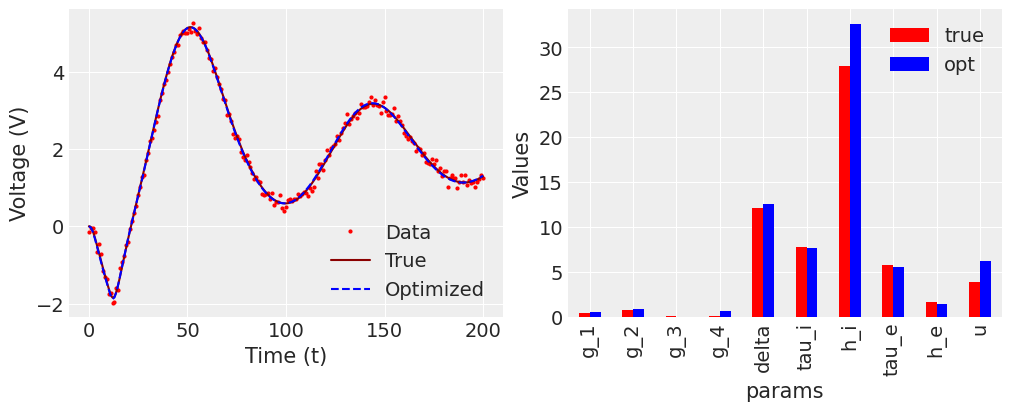

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

ax[0].plot(xpy_obs, 'or', markersize=2, label='Data') 
ax[0].set_xlabel('Time (t)')  
ax[0].set_ylabel('Voltage (V)')  
ax[0].plot(data['ts'], xpy_odeint, color='darkred', label='True') 
ax[0].plot(sim, 'b--', label='Optimized') 
ax[0].legend()

compared.plot(x='params', kind='bar', ax=ax[1], color=['red', 'blue'])
ax[1].set_ylabel('Values')

plt.show()


The **dynamics**  of the model are faithfully recovered by the parameters obtained through the optimization algorithm. However, we can see that the parameters found by the optimization process are not exactly the same as the true underlying generative parameters. Additionally, the optimized parameters can vary significantly between different runs. This is particularly common in non-convex optimization landscapes, where optimizers may get stuck in various local minima. This issue is exacerbated in models with **multimodality**, where different sets of parameters can yield similar outputs—often due to some parameters compensating for one another (the so-called degeneracy in neuroscience literature).


While optimization can provide a good fit to the data, it lacks the ability to quantify how confident we should be in the parameter estimates. Does the data strongly support these parameter values, or might a wide range of values perform nearly as well?


To assess this uncertainty, methods like **bootstrapping** can be useful. In bootstrapping, the model is repeatedly fitted on resampled data (generated by sampling from the original dataset). This process provides a distribution of parameter estimates, helping to understand the variability in the parameters. The result of bootstrapping typically includes a collection of parameter estimates or confidence intervals, which are informative but lack the probabilistic context provided by Bayesian methods.


Unlike bootstrapping (or, more generally, the **frequentist** approach), which focuses on the variability within the given data or dataset (hence need to repeat the measurements or here the model inversion), **Bayesian inference** explores the entire possible parameter space. It constructs a posterior distribution that reveals which regions of the parameter space are more likely, and which are less likely, offering a more comprehensive view of all possible parameter values. This allows Bayesian methods to provide a deeper understanding of the uncertainty and probabilistic nature of parameter estimates.

# Bayesian inference



Bayesian approaches go beyond just finding a single "best fit" parameter set. Instead, they provide a distribution of parameter estimates (the posterior distribution) which captures both the likely values of the parameters and the uncertainty around them. This comprehensive understanding of the parameter space is particularly valuable in making robust scientific conclusions.


To perform Bayesian inference, we aim to **estimate the posterior distribution** of model parameters, which can often be complex and high-dimensional. Since there is generally no analytical formula for the posterior, we rely on computational methods. One of the most common techniques is **Markov Chain Monte Carlo (MCMC)**, which helps us sample from the posterior distribution. MCMC methods allow us to explore the parameter space efficiently, even when the posterior is difficult to calculate directly.



## What is MCMC ?

**MCMC**  algorithms are powerful tools for **generating samples from a probability distribution** when direct sampling is not feasible. The core idea behind MCMC is to construct a Markov chain, which is a sequence of random samples where each sample depends only on the previous one.

Over time, the chain converges to its equilibrium state, at which point the samples drawn from the chain are representative of the target distribution. These samples, which may be correlated, are obtained by retrieving the history of states of the chain. The long-run distribution of the chain will approximate the desired probability distribution, allowing us to estimate various properties of the posterior distribution.

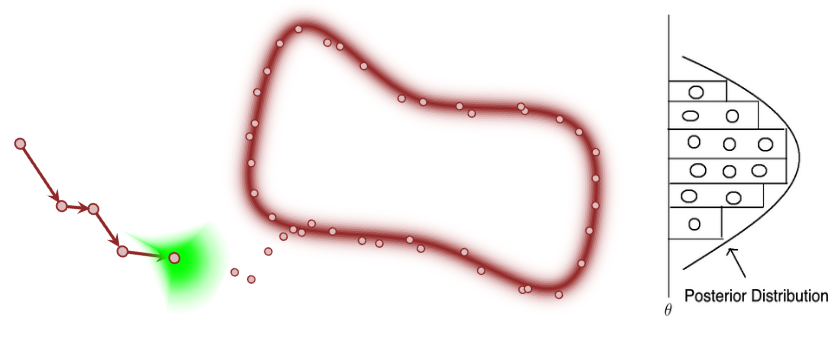

In [41]:
Image("Figs/markov.png", width=600)

**Hamiltonian Monte Carlo (HMC)** is a specialized type of MCMC that improves the efficiency of sampling by incorporating principles from physics. It leverages the concepts of momentum and energy to explore the parameter space in a structured and efficient way:

   Physical Analogy: In HMC, we treat the parameters as particles moving through a potential energy landscape, where the shape of the landscape is determined by our target distribution (the posterior). The particles can gain momentum, allowing them to traverse this landscape more efficiently, avoiding random, inefficient walks through parameter space.

   Simulating Motion: HMC uses Hamiltonian dynamics to simulate the motion of these particles. The dynamics calculate how the parameters should move, considering both their current position and momentum. This helps propose new samples that are more likely to be located in regions of higher probability, improving the exploration of the posterior.

   Leapfrog Integration: To update the parameters and their momenta, HMC employs a numerical technique known as leapfrog integration. This method conserves energy during the update, which helps maintain the overall structure of the distribution and prevents the system from diverging.

Overall, HMC can explore the parameter space much more quickly and efficiently than traditional MCMC methods, particularly in high-dimensional spaces, because it takes larger steps in areas of high probability and avoids inefficient random walks.

In this tutorial, we will use a state-of-the-art version of HMC, known as the No-U-Turn Sampler (NUTS), to perform Bayesian inference on the model. NUTS automatically adapts the step size and trajectory length, removing the need to manually tune these parameters, making it an ideal choice for complex models like ours.

## PPLs
    
Probabilistic Programming Languages (PPLs), such as *Stan*, *PyMC*, and *NumPyro*, provide flexible frameworks for defining complex probabilistic models and performing inference through methods like MCMC, enabling efficient Bayesian analysis and probabilistic reasoning. In this tutorial, we use **NumPyro** as we have observed faster convergence compared to Stan (see [Ref 1]), and it offers compatible speed-ups when using the NumPyro or Black JAX backends in PyMC.

## Prior

One of the main advantages of the Bayesian framework is the ability to leverage prior knowledge about the parameters of our model.

In this case, the basic knowledge we have is that the parameters represent biophysical quantities, for which negative values do not make sense. Therefore, we can use distributions that have positive support, such as truncated normal, log-normal, or gamma distributions.

Additionally, we can incorporate prior information from numerical experiments conducted by other researchers. For example, in [Ref 3], a set of gamma priors was proposed for the parameters of this model, based on phase space analysis. The gamma distribution is particularly useful here because it is controlled by its shape and scale parameters, allowing us to define prior beliefs about the expected range and variability of the parameters based on previous scientific findings.

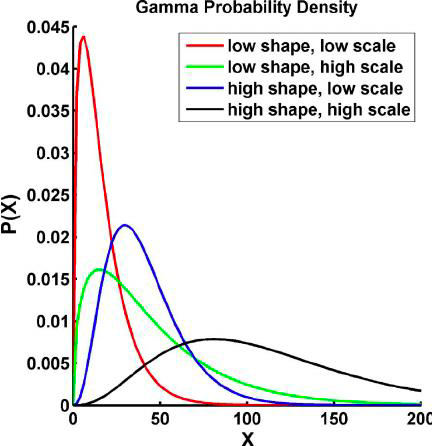

In [42]:
Image("Figs/gamma.png", width=300)

We set the hyper-parameters for the priors. For each of the model parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$, we fix a shape and a scale for its gamma prior.

In [43]:
shape = [18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale = [0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)
prior_specs = dict(shape=shape, rate=rate)

## Generative probabalitic model

A **generative model** is defined by the combination of a prior and a likelihood function.

In addition to the prior, a statistical model also requires a *likelihood* function. The likelihood is a measure of how well a particular model or set of parameters explains the observed data. In simpler terms, it answers the question: Given a specific set of parameters, how likely is it that we would observe the data we have? In the Bayesian context, the likelihood represents the contribution of the data to the estimation of the posterior distribution.

In this case, we will assume that our data is a *realization* from a normal distribution, centered around the exact output of the model (the mean), with some residual dispersion around it (the variance). The normal distribution likelihood is one of the most commonly used choices because it is mathematically tractable and has useful properties. Many statistical models, including ordinary least squares regression, rely on the assumption of normality (often formulated as the normality of the residuals), as this assumption simplifies both theoretical analysis and practical estimation.

In [44]:
def model(data, prior_specs):
    
    # Load the data
    ts = data['ts']
    ds = data['ds']
    nt_obs = data['nt_obs']
    x_init = data['x_init']
    xpy_obs = data['xpy_obs']

    # Define the prior distributions               
    g_1 = npr.sample('g_1', dist.Gamma(prior_specs['shape'][0], prior_specs['rate'][0]))
    g_2 = npr.sample('g_2', dist.Gamma(prior_specs['shape'][1], prior_specs['rate'][1]))
    g_3 = npr.sample('g_3', dist.Gamma(prior_specs['shape'][2], prior_specs['rate'][2]))
    g_4 = npr.sample('g_4', dist.Gamma(prior_specs['shape'][3], prior_specs['rate'][3]))
    delta = npr.sample('delta', dist.Gamma(prior_specs['shape'][4], prior_specs['rate'][4]))
    tau_i = npr.sample('tau_i', dist.Gamma(prior_specs['shape'][5], prior_specs['rate'][5]))
    h_i = npr.sample('h_i', dist.Gamma(prior_specs['shape'][6], prior_specs['rate'][6]))
    tau_e = npr.sample('tau_e', dist.Gamma(prior_specs['shape'][7], prior_specs['rate'][7]))
    h_e = npr.sample('h_e', dist.Gamma(prior_specs['shape'][8], prior_specs['rate'][8]))
    u = npr.sample('u', dist.Gamma(prior_specs['shape'][9], prior_specs['rate'][9]))
     
    # Lumped parameters    
    params_samples = [g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]
    
    # Forward model: call to the simulator
    xpy_hat = ERP_simulator(x_init, ts, params_samples)[::ds] #we downsample to be same size as the data
    
    # Likelihood: here we set a gaussian likelihood
    with plate('data', size=nt_obs):
        xpy_model = npr.deterministic('xpy_model', xpy_hat)
        xpy_ = npr.sample('xpy_', dist.Normal(xpy_model, 0.25), obs=xpy_obs) 

In [45]:
with npr.handlers.seed(rng_seed=1):
    trace = npr.handlers.trace(model).get_trace(data, prior_specs)
print(npr.util.format_shapes(trace))

Trace Shapes:      
 Param Sites:      
Sample Sites:      
     g_1 dist     |
        value     |
     g_2 dist     |
        value     |
     g_3 dist     |
        value     |
     g_4 dist     |
        value     |
   delta dist     |
        value     |
   tau_i dist     |
        value     |
     h_i dist     |
        value     |
   tau_e dist     |
        value     |
     h_e dist     |
        value     |
       u dist     |
        value     |
   data plate 201 |
    xpy_ dist 201 |
        value 201 |


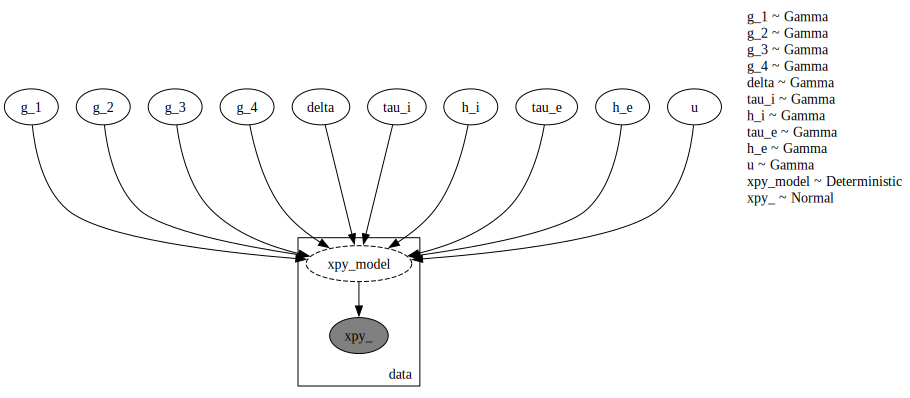

In [46]:
npr.render_model(model, model_args=(data, prior_specs), render_distributions=True, render_params=True)

## Prior predictive checks

Before proceeding with estimating the posterior distribution, it is a good and very useful practice to perform **perform sanity checks of our statistical model**. One of the key checks is prior predictive checks, which involve drawing samples from the priors, feeding them into the model, and inspecting the outputs.

The goal is to check whether the simulated data aligns with what you would expect based on prior knowledge, theoretical understanding, or previous empirical results. You should consider whether the predictions seem realistic and plausible, and whether they fall within the expected range of outcomes.
These checks help ensure that the prior reflects reasonable beliefs about the parameters and the data-generating process. Additionally, prior predictive checks are invaluable for debugging the model when unexpected behavior arises, as they can highlight discrepancies or issues early on in the process.

In the following,  we set the prior predictive function using "numpyro.infer.Predictive", and we run our model; notice the rng_key, it is for the random number generation process, and it returns a dictionnary containing samples from model parameters and outputs of the simulations:

In [47]:
n_prior = 100 # number of samples from prior


prior_predictive = Predictive(model, num_samples=n_prior)


_, rng_key = jax.random.split(rng_key)
prior_predictions = prior_predictive(rng_key, data, prior_specs)

In [48]:
prior_predictions ['xpy_model'].shape

(100, 201)

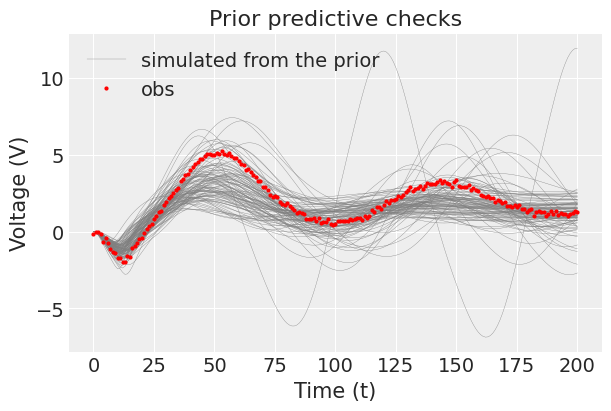

In [49]:
plt.figure(figsize=(6, 4))

for i_sample in range(n_prior) :
    plt.plot(data['ts_obs'], 
             prior_predictions['xpy_model'][i_sample],
             color='grey', lw=0.25, label='simulated from the prior')
    
plt.plot(data['ts_obs'], data['xpy_obs'], 'or', markersize=2, label='obs')
plt.title('Pyramidal Neurons')
plt.xlabel('Time (t)') 
plt.ylabel('Voltage (V)') 

plt.legend(*[*zip(*{l:h for h,l in zip(*plt.gca().get_legend_handles_labels())}.items())][::-1], loc='upper left')
plt.title('Prior predictive checks')
plt.show()

Prior predictions seem reasonnable. We can continue!

## Sampling from the posterior

We are only interested in samples from the Markov chain after it has reached **equilibrium**. To ensure that the chain has converged, it is customary to discard a number of warm-up or burn-in iterations. This allows us to focus on the relevant samples that reflect the true posterior distribution (stationary distbution or satisfying *ergodicity*, i.e.,  in which temporal averages and spatial (or ensemble) averages converge to the same value). In this case, 200 warm-up iterations are sufficient because we use some tricks that the model converges quickly. However, for most models, it is common to use anywhere from 1000 to 2000 warm-up iterations, or even more, depending on the complexity of the model or tools (see [Ref 3]). Indeed, that is why we use JAX to make the sampling process faster, and with some tricks (for the prior or algorithim's parameters) to do less work while maintaining efficiency.

It is also common practice to run **multiple chains** to ensure sufficient exploration of the parameter space. Running multiple chains allows us to check that all the chains eventually converge to the same distribution. This helps assess whether the Markov chains have explored the parameter space adequately and whether the results are reliable.

In [50]:
n_warmup, n_samples, n_chains = 200, 200, 4

**Question**: In the following, what are the algorithmic parameters such as target_accept_prob, max_tree_depth, and adapt_step_size? And how should they be set for efficiency, especially for our model? We used the experities for this model. For more details see appenix, and https://betanalpha.github.io/assets/case_studies/identifiability.html

In [51]:
# Set up the algorithm

kernel = NUTS(model, 
              target_accept_prob=0.8,
              max_tree_depth=10, 
              adapt_step_size=True, 
              init_strategy=init_to_sample()
             )

mcmc = MCMC(kernel, 
            num_warmup=n_warmup, 
            num_samples=n_samples, 
            num_chains=n_chains
           )

In [52]:
# Allez run it!
_, rng_key = jax.random.split(rng_key)
start_time = time.time()
mcmc.run(rng_key, data, prior_specs, extra_fields=('potential_energy', 'num_steps', 'diverging'))
print("NUTS' Numpyro took (sec):" , (time.time() - start_time))

Compiling.. :   0%|                                                                                                   | 0/400 [00:00<?, ?it/s]

  0%|                                                                                                                 | 0/400 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                                   | 0/400 [00:00<?, ?it/s]


  0%|                                                                                                                 | 0/400 [00:00<?, ?it/s]


Running chain 1:   0%|                                                                                                | 0/400 [00:22<?, ?it/s]


Running chain 3:   0%|                                                                                                | 0/400 [00:22<?, ?it/s]

Running chain 1:   5%|████▎                                                                                  | 20/400 [00:22<00:04, 8

NUTS' Numpyro took (sec): 51.577666997909546


Now, we monitor the outputs of the algorithm for the sake of convergence.

In [53]:
mcmc.print_summary(exclude_deterministic=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta     12.38      0.84     12.42     11.01     13.74    265.70      1.02
       g_1      0.54      0.13      0.53      0.32      0.73   1020.00      1.00
       g_2      0.65      0.07      0.65      0.54      0.78    285.86      1.01
       g_3      0.14      0.02      0.14      0.11      0.18    644.87      1.00
       g_4      0.22      0.03      0.21      0.17      0.28    642.46      1.00
       h_e      1.93      0.22      1.91      1.59      2.27    341.43      1.01
       h_i     19.39      3.33     19.04     13.67     24.21    521.76      1.00
     tau_e      5.70      0.36      5.67      5.07      6.19    252.57      1.02
     tau_i      7.65      0.20      7.66      7.33      7.97    430.57      1.01
         u      3.22      0.64      3.15      2.25      4.32    830.82      1.00

Number of divergences: 0


The **Gelman and Rubin** statistics $\hat R$ is a convergence diagnostic for MCMC algorithms. It measures the within- and between-chain convergence, with values close to 1 indicating good convergence. In practice, a value of 1.1 is often considered as a rule of thumb for convergence.

When the NUTS sampler encounters numerical errors in its integration and its path leads to infinity, it will raise a *divergence*. Divergences are a sign of very challenging model that makes exploration of the posterior distribution difficult. Ideally, there should be none. 

In [54]:
lp = -mcmc.get_extra_fields()['potential_energy']
mean_lp = np.mean(lp) 
print('Expected log joint density: {:.2f}'.format(mean_lp))

Expected log joint density: 78.52


lp for chain0= 78.62909725898768
lp for chain1= 78.7590399992046
lp for chain2= 78.38044631490868
lp for chain3= 78.29959159391763


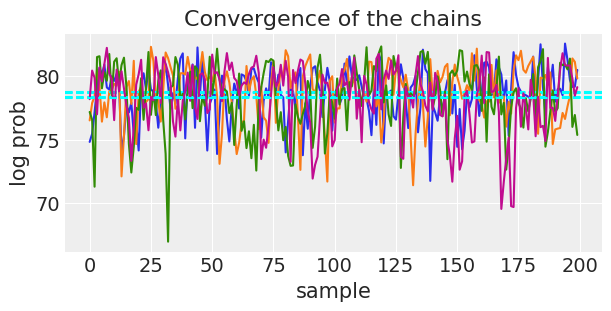

In [55]:
plt.figure(figsize=(6, 3))
for i in range(0, n_samples*n_chains, n_samples) : 
    plt.plot(lp[i:i+n_samples])
    print('lp for chain'+str(int(i/200))+'=', np.mean (lp[i:i+n_samples]))
    plt.axhline(np.mean(lp[i:i+n_samples]), color='cyan', linestyle='--')
plt.ylabel('log prob') ; plt.xlabel('sample')  ; plt.title('Convergence of the chains')
plt.show()

All chains have converged, now let's see our posterior samples.

Question: What does the value of *lp* depend on? Does it change with the noise level in the data and/or the model?

In [56]:
# get posterior samples
posterior_samples = mcmc.get_samples(group_by_chain=True)

In [57]:
# or we can use the arviz library which has great visualization for bayesian inference
az_post = az.from_numpyro(mcmc)

In [58]:
az_post

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

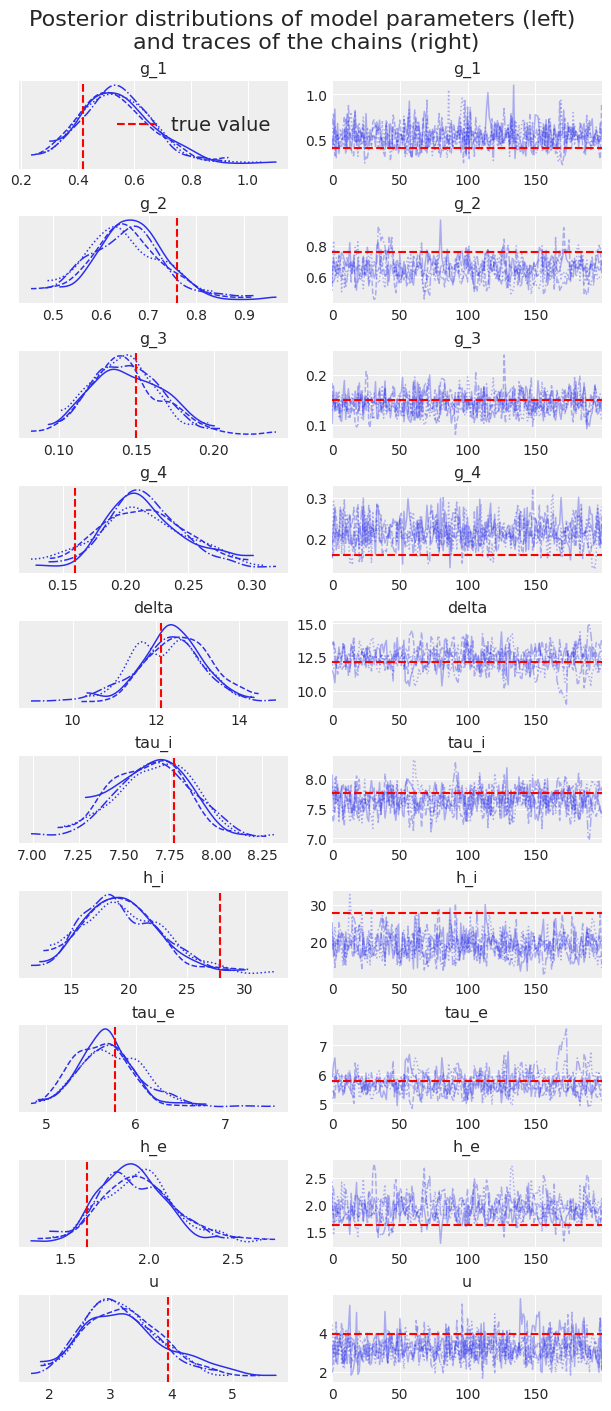

In [59]:
axes = az.plot_trace(
    az_post,
    var_names=params_names,
    compact=True,
    kind="trace",
    backend_kwargs={"figsize": (6, 14), "layout": "constrained"},)

for ax, true_val in zip(axes[:, 0], theta_true):
    ax.axvline(x=true_val, color='red', linestyle='--', label='true value')  
for ax, true_val in zip(axes[:, 1], theta_true):
    ax.axhline(y=true_val, color='red', linestyle='--')
    
axes[0, 0].legend()
plt.gcf().suptitle("Posterior distributions of model parameters (left) \n" +\
                   "and traces of the chains (right)", fontsize=16)
plt.show()

The obtained **(marginal) posterior distributions** of the model parameters mostly encompass the true values used to generate the data. From these distributions, we can compute quantiles, mean, median, variance, and other statistical summaries.

As a side note, remember that the Markov chains (shown in the right panel) produce auto-correlated series of values. This means that the *effective sample size* is lower than the number of drawn samples, which should be kept in mind when deriving quantities of interest. However, this topic is outside the scope of this notebook.

We can now plot the marginal posterior distributions of the model parameters alongside the prior distributions. This comparison will allow us to see which parameters have been updated by the data and which ones have not changed significantly.

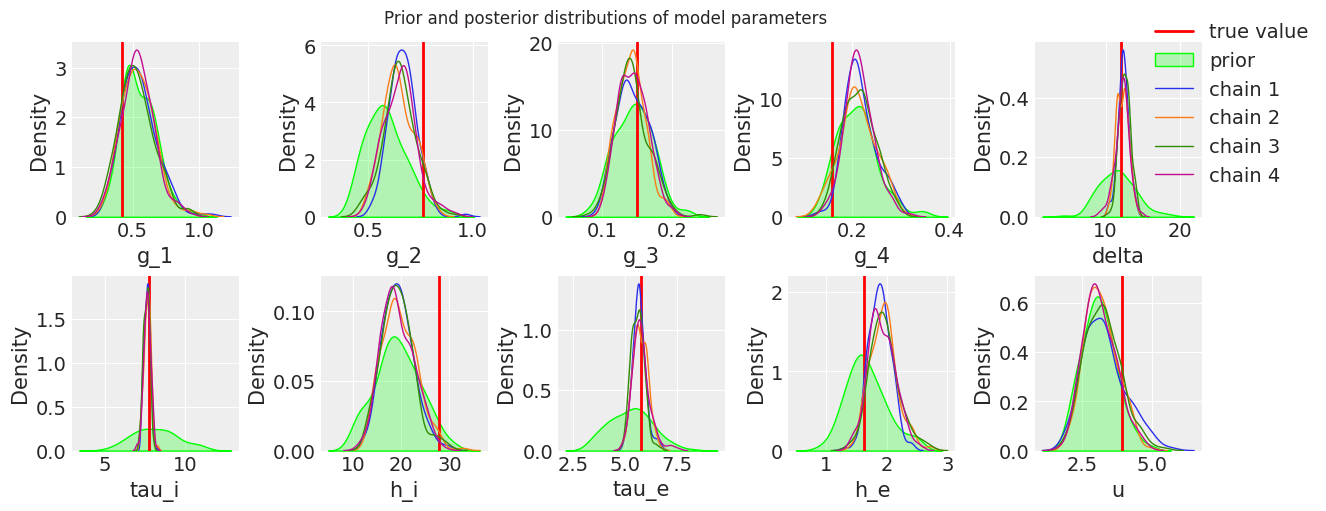

In [60]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(12, 5))

for i_prm, prm in enumerate(params_names) :
    
    ax[i_prm//5, i_prm%5].set(xlabel=prm)
    ax[i_prm//5, i_prm%5].axvline(theta_true[i_prm], color='red', label='true value', lw=2)
    sns.kdeplot(prior_predictions[prm], ax=ax[i_prm//5, i_prm%5], color='lime', fill=True, label='prior')
    
    for i_chain in range(n_chains) :
        sns.kdeplot(az_post.posterior[prm].sel(chain=i_chain), ax=ax[i_prm//5, i_prm%5], lw=1, 
                    label='chain ' + str(i_chain+1))
    

fig.legend(*[*zip(*{l:h for h,l in zip(*plt.gca().get_legend_handles_labels())}.items())][::-1], 
           bbox_to_anchor=(1.1, 1))
fig.suptitle('Prior and posterior distributions of model parameters')
plt.show()

## Posterior predictive checks

We can also generate fit to the data  (posterior predictive samples), which simulate data based on the fitted model and faithfully recover the dynamics of the observed variable.

For each sample from the joint posterior distribution (a set of parameter values), we input these parameters into the generative model and obtain a simulation of $x_9$ corresponding to that specific sample. By repeating this process for multiple samples, we can visualize how well the model matches the observed data and assess the model's predictive power.

In [61]:
posterior_predictive = Predictive(model, mcmc.get_samples())
_, rng_key = jax.random.split(rng_key)
post_pred_samples = posterior_predictive(rng_key, data, prior_specs)

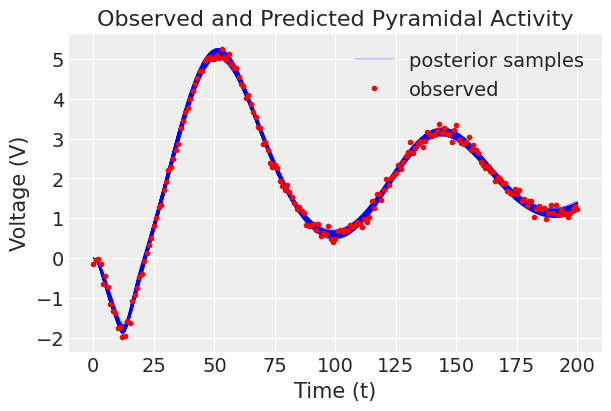

In [62]:
fig, ax = plt.subplots(figsize=(6, 4))

for i in range(len(post_pred_samples['xpy_'])) :
    ax.plot(post_pred_samples['xpy_model'][i], color='b', lw=0.25, label='posterior samples')
    
ax.plot(data['xpy_obs'], 'or', markersize=3, label='observed')

ax.legend(*[*zip(*{l:h for h,l in zip(*plt.gca().get_legend_handles_labels())}.items())][::-1], loc='upper right')

plt.title('Observed and Predicted Pyramidal Activity')
plt.xlabel('Time (t)') 
plt.ylabel('Voltage (V)') 
plt.show()

**Exercise:**
    
1)  Tune the Algorithmic Parameters:
    1.1) Target acceptance probability: Set it to 0.8 and adjust slightly based on performance. What happens if you          increase it to 0.9 or decrease it to 0.7?
    1.2) Step size: Tune the step size to see its effect on convergence. Try smaller or larger values and observe  
         the behavior.
    1.3) Max tree depth: Test different values of max_tree_depth for the HMC or NUTS sampler (e.g., 10 vs 15). How          does the sampling time change with larger tree depths?
   
   
    
2) Plot the join ditbution between parameters. Do you see the banana shapes?!!
   
   
    
3) Experiment with the Prior: 
     Set informative/noninformative priors for model parameters. For instance, use a truncated normal prior for    
     parameters that should be positive (e.g., biophysical parameters). Test the impact of changing the prior. 
     
  
  
     
4) Weighted stacking the Chains (Advanced level); The main question is what we should do if we see different MCMC converge to differentt solution. See https://jmlr.org/papers/volume23/20-1426/20-1426.pdf
      
    
    
5) Algorithmic benchmark to compare with MCMC; 
       In this notebook, we used NUTS sampling for ERPs in MEG/EEG, which is the state-of-the-art gradient-based MCMC approach for obtaining posterior samples in these contexts. However, NumPyro and PyMC offer alternative methods such as Variational Inference, Laplace approximation, and other optimization-based techniques. In Ref[1], an extensive benchmark and algorithmic comparison of these methods is provided.However, when working with more complex data modalities such as fMRI BOLD data, the situation becomes more challenging. For large-scale models (e.g., those involving the brain's full connectivity), the likelihood function can become intractable due to the high dimensionality and the complexity of the underlying generative model. In these cases, MCMC sampling can become computationally prohibitive and impractical.
     
     
    One potential solution to this problem is to *reparameterize* the probabilistic model in a different space that leads to faster convergence. This reparameterization could alleviate the issues associated with high-dimensional parameter spaces and slow mixing, although it can require significant model knowledge.
       
    An efficient solution is the use of Simulation-Based Inference (SBI). SBI methods, such as Approximate Bayesian Computation (ABC), allow for likelihood-free inference, enabling parameter estimation without needing to explicitly calculate the likelihood function. Although they suffer from the curse of dimentionality, and needs a threshod to accept/reject the samples, Instead advanved SBI using a class of deep learning generative model called **Normaling Flows** uses low-dim data features  from random simuations and learn an inverible map to the parameter space. This makes SBI especially useful when the likelihood is expensive or impossible to compute, as is often the case with complex, high-dimensional models like those used for fMRI BOLD data. See https://github.com/sbi-dev/sbi

# References

[1] Baldy et al., Dynamic Causal Modeling in Probabilistic Programming Languages. BioRxiv 2024.

[2] Olivier David et al., Dynamic causal modeling of evoked responses in EEG and MEG. NeuroImage 2006. 

[3] Biswa Sengupt et al., Gradient-free MCMC methods for dynamic causal modelling. NeuroImage 2015.
 